In [1]:
import math
import copy
import json
import time
import random
import sys, os
import itertools
import numpy as np
import pandas as pd
import urllib.request
from hashlib import new
from sklearn.cluster import KMeans
from py2opt.routefinder import RouteFinder
import matplotlib.pyplot as plt

In [2]:
start_time = time.time()

In [3]:
# bus_combis.py

# for pre-optimization
def get_min_and_max_no_of_clusters(buses, data):
    bus_capacity_list = []
    for bus in buses:
        bus_capacity_list.append(bus['capacity'])
    bus_capacity_list.sort()

    passengers = len(data)
    min_cluster = math.ceil(passengers / bus_capacity_list[-1])
    max_cluster = math.ceil(passengers / bus_capacity_list[0])
    
    return min_cluster, max_cluster


# for pre-optimization
def get_bus_capacities(buses):
    bus_capacities = []
    for bus in buses:
        bus_capacities.append(bus['capacity'])
    bus_capacities.sort()
    
    return bus_capacities


# for pre-optimization
def get_min_and_max_no_of_clusters(total_passengers, bus_capacities):
    min_cluster = math.ceil(total_passengers / bus_capacities[-1])
    max_cluster = math.ceil(total_passengers / bus_capacities[0])
    
    return min_cluster, max_cluster


# for pre-optimization
def get_bus_combis_without_sorting(min_cluster, max_cluster, total_passengers, bus_capacities):
    bus_combinations_before_sorting_by_cost = {}

    for i in range(min_cluster, max_cluster + 1):
        n_cluster = i
        bus_combis_for_n_cluster = []
        for combination in itertools.combinations_with_replacement(bus_capacities, n_cluster):
            if sum(combination) > total_passengers:
                bus_combis_for_n_cluster.append(combination)

        bus_combinations_before_sorting_by_cost[i] = bus_combis_for_n_cluster
        
    return bus_combinations_before_sorting_by_cost


# for pre-optimization
# compile the cost of all the bus combis into a dict for sorting later
def get_cost_dictionary(min_cluster, max_cluster, bus_combis_before_sorting_by_cost, buses):
    cost_dictionary = {}

    for i in range(min_cluster, max_cluster + 1):
        bus_combis_for_current_n_of_cluster = bus_combis_before_sorting_by_cost[i]
        current_cost_dictionary_for_current_n_of_cluster = {}
        for j in range(len(bus_combis_for_current_n_of_cluster)):
            current_combi = bus_combis_for_current_n_of_cluster[j]
            current_cost = 0
            for current_bus_capacity in current_combi:
                for bus in buses:
                    if current_bus_capacity == bus['capacity']:
                        current_cost += bus['price_per_hour']
            current_cost_dictionary_for_current_n_of_cluster[j] = current_cost
        cost_dictionary[i] = current_cost_dictionary_for_current_n_of_cluster
                    
    return cost_dictionary


# for pre-optimization
def sort_cost_dictionary(cost_dictionary, min_cluster, max_cluster):
    sorted_cost_dictionary = {}
    for i in range(min_cluster, max_cluster + 1):
        sorted_cost_dict = sorted(cost_dictionary[i].items(), key=lambda x: x[1])
        sorted_cost_dictionary[i] = sorted_cost_dict
    return sorted_cost_dictionary


# for pre-optimization
def get_sorted_bus_combis(min_cluster, max_cluster, bus_combis_before_sorting_by_cost, buses):
    cost_dictionary = get_cost_dictionary(min_cluster, max_cluster, bus_combis_before_sorting_by_cost, buses)
    sorted_cost_dictionary = sort_cost_dictionary(cost_dictionary, min_cluster, max_cluster)
    
    bus_combinations = {}
    for i in range(min_cluster, max_cluster + 1):
        # for current_n of cluster 
        bus_combi = []
        sorted_cost_list_of_bus_combi = sorted_cost_dictionary[i]
        for index_and_cost in sorted_cost_list_of_bus_combi:
            index = index_and_cost[0]
            bus_combi.append(bus_combis_before_sorting_by_cost[i][index])

        bus_combinations[i] = bus_combi      

    return bus_combinations


# for pre-optimization
def get_bus_combi_for_one_n_cluster(no_of_clusters, sorted_no_of_people, total_passengers, buses, bus_capacities):
    
    # bus combis without sorting
    bus_combis_for_n_cluster = []
    for combination in itertools.combinations_with_replacement(bus_capacities, no_of_clusters):
        if sum(combination) > total_passengers:
            bus_combis_for_n_cluster.append(combination)
        
    # cost dictionary without sorting
    current_cost_dictionary = {}
    for i in range(len(bus_combis_for_n_cluster)):
        current_combi = bus_combis_for_n_cluster[i]
        current_cost = 0
        for current_bus_capacity in current_combi:
            for bus in buses:
                if current_bus_capacity == bus['capacity']:
                    current_cost += bus['price_per_hour']
        current_cost_dictionary[i] = current_cost
    
    # sort cost dictionary
    sorted_cost_dict = sorted(current_cost_dictionary.items(), key=lambda x: x[1])
    
    sorted_bus_combis = []
    for index_and_cost in sorted_cost_dict:
        index = index_and_cost[0]
        sorted_bus_combis.append(bus_combis_for_n_cluster[index])
    
    for sorted_bus_combi in sorted_bus_combis:
        if all(x < y for x, y in zip(tuple(sorted_no_of_people), sorted_bus_combi)):
            return sorted_bus_combi
        
    return None
    

# bus capacities are alraedy sorted from smallest to biggest
def get_smallest_bus_for_given_no_of_passengers(bus_capacities, no_of_passengers):
    for cap in bus_capacities:
        if no_of_passengers <= cap:
            return cap

In [4]:
# coordinates.py

def get_coords_of_single_location(coordinates, keyword):
    keyword = keyword.lower()
    search = coordinates.copy()
    search = search[search["station_name"].notna()]
    search["station_name"] = search["station_name"].str.lower()
    result = search[search["station_name"].str.contains(keyword)].iloc[0]
    return [
        result["latitude"],
        result["longitude"]
    ]

In [5]:
# cost.py

# calculate costs for only one bus combination
def get_cost_of_one_bus_combi(bus_sizes_tuple, bus_durations_tuple, buses): # e.g. (27,33)
    cost = 0

    for i in range(len(bus_sizes_tuple)):
        
        for bus in buses:
            if bus_sizes_tuple[i] == bus['capacity']:
                # add the costs based on the sizes and durations of buses used
                no_of_minutes = bus_durations_tuple[i]
                no_of_hours = math.ceil(no_of_minutes / 60)
                cost += bus['price_per_hour'] * no_of_hours

    return cost


# for pre-optimization
# calculate costs for only one bus combination, and also convert the bus_durations_tuple from seconds to minutes
def get_cost_and_durations_in_mins_of_one_bus_combi(bus_sizes_tuple, bus_durations_tuple, buses): # e.g. (27,33)
    cost = 0
    new_duration_in_mins = []
    
    for i in range(len(bus_sizes_tuple)):
        for bus in buses:
            if bus_sizes_tuple[i] == bus['capacity']:
                # set the new durations to be in minutes
                bus_durations_tuple[i] = math.ceil(bus_durations_tuple[i] / 60)
                new_duration_in_mins.append(bus_durations_tuple[i])

                # add the costs based on the sizes and durations of buses used
                no_of_minutes = bus_durations_tuple[i]
                no_of_hours = math.ceil(no_of_minutes / 60)
                cost += bus['price_per_hour'] * no_of_hours

    return cost, new_duration_in_mins


# for pre-optimization
# calculate costs for each of the different numbers of clusters
def get_cost_and_durations_in_mins(tsp_durations, chosen_bus_combis, buses):
    default_costs = []
    durations_in_minutes = []
    
    copy_of_durations = copy.deepcopy(tsp_durations)
    
    for i in range(len(chosen_bus_combis)):
        cost, durations_in_min = get_cost_and_durations_in_mins_of_one_bus_combi(chosen_bus_combis[i], copy_of_durations[i], buses)
            
        default_costs.append(cost)
        durations_in_minutes.append(durations_in_min)
    
    return default_costs, durations_in_minutes

In [6]:
# data_processing.py

# for pre-optimization
def get_data_consolidated(data, final_venue):
    data_numbers = {}
    # {'Tuas Crescent MRT Station': 6,
    #  'Pioneer MRT Station': 18,}

    data_coordinates = {}
    # {'Tuas Crescent MRT Station': ['1.32102695188066', '103.649078232635'],
    #  'Pioneer MRT Station': ['1.33758688240768', '103.697321513018']}

    data_list = []
    # [['Tuas Crescent MRT Station', '1.32102695188066', '103.649078232635'],
    #  ['Pioneer MRT Station', '1.33758688240768', '103.697321513018']]

    for location in data:
        if data_numbers.get(location[0]) is not None:
            no_of_this_location = data_numbers[location[0]]
            no_of_this_location += 1
            data_numbers[location[0]] = no_of_this_location
        else:
            data_numbers[location[0]] = 1
            data_coordinates[location[0]] = location[1:3]
            data_list.append(location)
            
    data_list_with_final_venue = data_list.copy()
    data_list_with_final_venue.append(final_venue)
            
    return data_numbers, data_coordinates, data_list, data_list_with_final_venue


# for pre-optimization
def add_coordinates_to_locations(coordinates, data, final_venue):
    # add coordinates to locations list
    for location in data:
        coords = get_coords_of_single_location(coordinates, location[0].rpartition(' MRT')[0])
        for coord in coords:
            location.append(coord)

    # add coordinates to final venue
    final_venue_coords = get_coords_of_single_location(coordinates, final_venue[0].rpartition(' MRT')[0])
    for coord in final_venue_coords:
        final_venue.append(coord)

In [7]:
# kmeans.py

# for pre-optimization
def fit_kmeans(data, min_cluster, max_cluster, bus_combinations):
    df = pd.DataFrame(data, columns = ['mrt', 'lat', 'long'])
    df_lat_long = df.iloc[:,1:3]
    
    no_of_people_in_each_cluster = [] # to get number of people in each bus at the end
    sorted_no_of_people_in_each_cluster = [] # to get the bus combinations
    cluster_allocations_of_locations = []
    chosen_bus_combis = []
    chosen_bus_combis_indexes = []
    selected_cluster_sizes = []

    for i in range(min_cluster, max_cluster + 1):

        # all possible bus combis
        n_bus_cluster_combi = bus_combinations[i]

        # run KMeans
        clf = KMeans(n_clusters = i)
        clf.fit_predict(df_lat_long)
        clf = clf.labels_

        # get the sizes of clusters
        kmeans_pred_cluster = []
        for j in range(i):
            kmeans_pred_cluster.append(np.count_nonzero(clf == j))
        sorted_kmeans_pred_cluster = sorted(kmeans_pred_cluster)

        # find the bus combination for this cluster size and add to overall bus combis list
        for j in range(len(n_bus_cluster_combi)):
            chosen_bus_combi = n_bus_cluster_combi[j]
            if all(x < y for x, y in zip(tuple(sorted_kmeans_pred_cluster), chosen_bus_combi)):

                # if there is a suitable bus combi, add the results to their overall lists
                print('{}-mean clustering for total size of'.format(i), len(data), ":", kmeans_pred_cluster)
                sorted_no_of_people_in_each_cluster.append(sorted_kmeans_pred_cluster)
                no_of_people_in_each_cluster.append(kmeans_pred_cluster)

                print('Chosen bus combi', chosen_bus_combi)
                chosen_bus_combis.append(chosen_bus_combi)
                chosen_bus_combis_indexes.append(j)

                print('Assigned cluster for each of the {} stations'.format(len(data)), ":", clf, "\n")
                cluster_allocations_of_locations.append(clf)    

                selected_cluster_sizes.append(i)
                break

    return sorted_no_of_people_in_each_cluster, no_of_people_in_each_cluster, cluster_allocations_of_locations, \
                chosen_bus_combis, chosen_bus_combis_indexes, selected_cluster_sizes


# for pre-optimization
# clusters are sorted starting from lowest number of passengers in each n_cluster
def get_clustered_locations_list_before_tsp(selected_cluster_sizes, cluster_allocations_of_locations, data, \
                                           sorted_no_of_people_in_each_cluster, no_of_people_in_each_cluster):
    clustered_locations_list_before_tsp = []

    for i in range(len(selected_cluster_sizes)):
        cluster = {}
        for j in range(selected_cluster_sizes[i]):
            cluster[j] = []

        # adjust cluster no such that lower no means less passengers in that cluster
        cluster_allocations_of_locations[i] = adjust_cluster_no_of_cluster_allocations_of_locations( \
            cluster_allocations_of_locations[i], sorted_no_of_people_in_each_cluster[i], no_of_people_in_each_cluster[i])

        counter = 0
        for j in cluster_allocations_of_locations[i]:
            if data[counter] not in cluster[j]:
                cluster[j].append(data[counter])
            counter += 1
            
        clustered_locations_list_before_tsp.append(cluster)

    return clustered_locations_list_before_tsp


# for pre-optimization
# original: cluster_allocations_of_locations[i] = [3 3 1 1 4 4 4 0 0 2 2]
# after: cluster_allocations_of_locations[i] = [2 2 1 1 3 3 0 0 4 4 4], where cluster 0 has the least passengers
def adjust_cluster_no_of_cluster_allocations_of_locations(cluster_allocations_of_locations, \
                            sorted_no_of_people_in_each_cluster, no_of_people_in_each_cluster):
    
    new_index_list = [None] * len(no_of_people_in_each_cluster)
    
    # for each of the no_of_people, find the index in sorted_no_of_ppl and set the number in cluster allocations of locations to that index
    for i in range(len(no_of_people_in_each_cluster)):
        indexes_in_sorted_no_of_ppl = [i for i, j in enumerate(sorted_no_of_people_in_each_cluster) if no_of_people_in_each_cluster[i]]
        # if there are two clusters with same no of ppl, we need to take the next index
        for index in indexes_in_sorted_no_of_ppl:
            if index not in new_index_list:
                new_index_list[i] = index
                break
        
        
    new_cluster_allocations_of_locations = [new_index_list[i] for i in cluster_allocations_of_locations]

    return new_cluster_allocations_of_locations

In [8]:
# libs_adjustments.py

# for pre-optimization, after Kmeans library
# adjust lists for single cluster since Kmeans only add multi-clusters info to these three lists
def adjust_lists_for_single_cluster(data_list, total_passengers, bus_capacities, clustered_locations_list_before_tsp, \
                                    sorted_no_of_people_in_each_cluster, chosen_bus_combis, selected_cluster_sizes):
    temp_location_list = {}
    temp_location_list[0] = data_list.copy()
    clustered_locations_list_before_tsp.insert(0, temp_location_list)
    
    no_of_people = []
    no_of_people.append(total_passengers)
    sorted_no_of_people_in_each_cluster.insert(0, no_of_people)
    
    selected_cluster_sizes.insert(0, 1)
    
    for cap in bus_capacities:  # bus caps are already sorted in ascending order
        if total_passengers <= cap:
            bus_combi = []
            bus_combi.append(cap)
            chosen_bus_combis.insert(0, bus_combi)
            break

In [9]:
# overall_result.py

# for pre-optimization
def get_overall_dict_for_optimization(selected_cluster_sizes, default_costs, no_of_people_in_each_cluster, 
                                     chosen_bus_combis, tsp_durations_in_mins, locations_with_no_of_ppl,
                                     tsp_result_locations_list):
    counter = 0
    overall_dict = {}
    cluster_keys = []

    for i in selected_cluster_sizes:
        key_for_n_cluster = str(i) + "-cluster"
        extra_key = 2
        while overall_dict.get(key_for_n_cluster):
            key_for_n_cluster = str(i) + "-" + str(extra_key) + "-cluster"
            extra_key += 1
            
        # store all the clusters used in this dataset
        cluster_keys.append(key_for_n_cluster)
            
        dict_for_n_cluster = {}

        # cost for all the clusters in n_cluster
        current_cost = default_costs[counter]
        dict_for_n_cluster["total_cost"] = current_cost
        dict_for_n_cluster["no_of_clusters"] = i

        # get details for each of the cluster
        initial_no_of_people_in_n_cluster = no_of_people_in_each_cluster[counter] # e.g. to get (27, 33)
        chosen_bus_combis_for_n_cluster = chosen_bus_combis[counter]
        durations_for_n_cluster = tsp_durations_in_mins[counter]
        locations_for_n_cluster_with_no_of_ppl = locations_with_no_of_ppl[counter]
        locations_for_n_cluster = tsp_result_locations_list[counter]
        
        dict_for_n_cluster["bus_combi"] = chosen_bus_combis_for_n_cluster

        for j in range(i):
            key_for_current_cluster = "cluster_" + str(j + 1)
            dict_for_current_cluster = {}
            dict_for_current_cluster["duration"] = durations_for_n_cluster[j]
            dict_for_current_cluster["no_of_passengers"] = initial_no_of_people_in_n_cluster[j]
            dict_for_current_cluster["bus_size"] = chosen_bus_combis_for_n_cluster[j]
            dict_for_current_cluster["locations_with_no_of_ppl"] = locations_for_n_cluster_with_no_of_ppl[j]
            dict_for_current_cluster["locations_with_coordinates"] = locations_for_n_cluster[j]
            dict_for_current_cluster["mean_coordinates_for_initial_locations_list"] = calculate_mean_coordinates_of_locations_list(locations_for_n_cluster[j])

            dict_for_n_cluster[key_for_current_cluster] = dict_for_current_cluster

        overall_dict[key_for_n_cluster] = dict_for_n_cluster

        counter += 1

    return overall_dict, cluster_keys


# print overall_dict with all possible n_cluster sizes
def print_overall_dict_as_more_readable_results(overall_dict, final_venue):
    for n_cluster_key in overall_dict.keys():
        n_cluster = overall_dict[n_cluster_key]
        print("\n-- For", n_cluster_key, "with total cost of", n_cluster["total_cost"], "bucks --")
        print_n_cluster_as_more_readable_results(n_cluster, final_venue)
        
# print individual n_cluster
def print_n_cluster_as_more_readable_results(n_cluster, final_venue):
    print("(New) number of clusters:", n_cluster["no_of_clusters"])
    print("Bus combination used:", n_cluster["bus_combi"], "\n")
    
    bus_counter = 1
    for cluster_key in n_cluster.keys():
        if cluster_key != "total_cost" and cluster_key != "no_of_clusters" and cluster_key != "bus_combi":
            cluster = n_cluster[cluster_key]
        
            print("Bus", bus_counter, "with bus size", cluster["bus_size"])
            print_cluster_as_more_readable_results(cluster, final_venue)
            
            bus_counter += 1

# print a cluster in a n_cluster
def print_cluster_as_more_readable_results(cluster, final_venue):
    print("No of passengers in this bus -", cluster["no_of_passengers"])
    print("Duration to be taken -", cluster["duration"], "min")
    
    print("Route:")
    locations_with_no_of_ppl = cluster["locations_with_no_of_ppl"]
    for location in cluster["locations_with_coordinates"][:-1]:
        print("\t", location[0],"-", locations_with_no_of_ppl[location[0]], "person(s)")
    print("\t", final_venue[0])
    print()
    

# find average coordinates of all locations in a cluster
# so that we can find the nearest cluster later
def calculate_mean_coordinates_of_locations_list(locations_list):
    sum_of_latitudes = 0
    sum_of_longitudes = 0
    for location in locations_list:
        sum_of_latitudes += float(location[1])
        sum_of_longitudes += float(location[2])
        
    mean_coordinates = []
    mean_coordinates.append(sum_of_latitudes / len(locations_list))
    mean_coordinates.append(sum_of_longitudes / len(locations_list))
    
    return mean_coordinates


def pretty_print_dict(overall_dict):
    json_object = json.loads(json.dumps(overall_dict))
    json_formatted_str = json.dumps(json_object, indent=2)
    print(json_formatted_str)

In [10]:
# time_matrix.py

# OSRM is only called once at the start to build the overall time matrix list
# Later time matrices needed is obtained from this overall time matrix list

# for pre-optimization
# concatenate all the coordinates of the MRT stations
# returns request url for osrm
def build_request_for_osrm(data_coordinates, final_venue):
    new_addresses = data_coordinates.copy()
    
    # add final venue to the dictionary if not inside
    if new_addresses.get(final_venue[0]) is None:
        new_addresses[final_venue[0]] = final_venue[1:3]
    
    coordinates_string = ""
    for key in new_addresses.keys():
        coordinates_string += str(new_addresses[key][1]) # add longitude
        coordinates_string += ","
        coordinates_string += str(new_addresses[key][0]) # add latitude
        coordinates_string += ";"
    coordinates_string = coordinates_string[:-1]
    
    # new_request = 'http://localhost:5000/table/v1/driving/' + coordinates_string + "?annotations=duration"
    new_request = 'http://ec2-54-169-10-10.ap-southeast-1.compute.amazonaws.com:5000/table/v1/driving/' + coordinates_string + "?annotations=duration"
    
    return new_request


# form request url and call osrm with it
def get_time_matrix_from_osrm(data_coordinates, final_venue):
    # concatenate their coordinates and send to osrm to get their time matrix
    new_request = build_request_for_osrm(data_coordinates, final_venue)
    # print(new_request)
    
    jsonResult = urllib.request.urlopen(new_request).read()
    response = json.loads(jsonResult)
    
    return np.array(response['durations']) # distances[i][j] is from i-th source to j-th destination


# translate the 2D time matrix array into a list of dictionaries
# [{'source': ['Tuas Crescent MRT Station (EW31)', '1.32102695188066', '103.649078232635'],
#   'destination': ['Woodlands MRT Station (NS9)', '1.43606698186149', '103.787930806962'],
#   'duration': 1517.1}]
def build_overall_time_matrix_list(data_list_with_final_venue, overall_time_matrix):
    time_matrix_list = []
    for i in range(len(data_list_with_final_venue)): 
        for j in range(len(data_list_with_final_venue)):
            location_pair_dict = {}
            location_pair_dict["source"] = data_list_with_final_venue[i]
            location_pair_dict["destination"] = data_list_with_final_venue[j]
            location_pair_dict["duration"] = overall_time_matrix[i][j]
            
            time_matrix_list.append(location_pair_dict)
    
    return time_matrix_list


# Form another time matrix dictionary for faster search:
# {'Tuas Crescent MRT Station (EW31)': {
#     'Tuas Crescent MRT Station (EW31)': 0.0
#     'Woodlands MRT Station (NS9)': 1517.1
#    }
# }
def get_faster_overall_matrix(overall_time_matrix_list, data_list_with_final_venue):
    location_list_without_coordinates = [item[0] for item in data_list_with_final_venue]
    faster_overall_time_matrix_list = {item: {} for item in location_list_without_coordinates}
    current_key = overall_time_matrix_list[0]["source"][0]

    for location_pair in overall_time_matrix_list:
        if location_pair["source"][0] == current_key:
            faster_overall_time_matrix_list[current_key][location_pair["destination"][0]] = location_pair["duration"]
        else:
            current_key = location_pair["source"][0]
            faster_overall_time_matrix_list[current_key][location_pair["destination"][0]] = location_pair["duration"]
    
    return faster_overall_time_matrix_list


# location_list: all the locations to generate this time matrix for
def form_matrix_from_overall_list(location_list, faster_overall_time_matrix_list):
    matrix_size = len(location_list)
    matrix_array = np.zeros((matrix_size, matrix_size))
    
    for i in range(len(location_list)):
        for j in range(len(location_list)): 
            source_location_key = location_list[i][0]
            destination_location_key = location_list[j][0]
            matrix_array[i][j] = faster_overall_time_matrix_list[source_location_key][destination_location_key]

    # print("Matrix array:", matrix_array)
    return matrix_array

In [11]:
# tsp.py

def get_tsp_permutation_and_duration_for_single_time_matrix(locations_list, matrix, faster_overall_time_matrix_list, final_venue):
    sys.stdout = open(os.devnull, 'w') # to prevent printing of py2opt library things
    
    route_finder = RouteFinder(matrix, locations_list, iterations = 10)
    duration, route = route_finder.solve()
    
    if route[-1] != final_venue:
        route, duration = post_process_2_opt_results(route, duration, faster_overall_time_matrix_list, final_venue)

    sys.stdout = sys.__stdout__ # to resume printing for the program

    return route, duration + 900    # osrm durations are too small so add another 15min to each route (not sure why)


def post_process_2_opt_results(route, duration, faster_overall_time_matrix_list, final_venue):
    best_duration = duration
    final_venue_index = route.index(final_venue)
    
    # route[index] = ["Hougang MRT Station (NE14)", "1.37129229221246", "103.892380518741"]
    # route[index][0] = "Hougang MRT Station (NE14)", which is the key for overall TM list
    best_duration -= faster_overall_time_matrix_list[route[final_venue_index][0]][route[final_venue_index + 1][0]]
    best_duration += faster_overall_time_matrix_list[route[-1][0]][route[0][0]]
    
    best_route = route[final_venue_index + 1:] + route[:final_venue_index + 1]
    
    return best_route, best_duration


# for pre-optimization
# get result from tsp library
def get_tsp_permutations_and_durations(clustered_locations_list_before_tsp, faster_overall_time_matrix_list, final_venue):
    tsps = []
    tsp_durations = []

    for i in range(len(clustered_locations_list_before_tsp)):

        tsp = []
        tsp_duration = []

        # for each of the chosen bus combi route
        for j in range(len(clustered_locations_list_before_tsp[i])):
            temp_location_list_with_final_venue = copy.deepcopy(clustered_locations_list_before_tsp[i][j])
            temp_location_list_with_final_venue.append(final_venue)
            matrix = form_matrix_from_overall_list(temp_location_list_with_final_venue, faster_overall_time_matrix_list)

            permutation, duration = get_tsp_permutation_and_duration_for_single_time_matrix(temp_location_list_with_final_venue, matrix, faster_overall_time_matrix_list, final_venue)

            tsp.append(permutation)
            tsp_duration.append(duration)

        tsps.append(tsp)
        tsp_durations.append(tsp_duration)

    print("\nTSP: Got the routes and durations for all the initial clusters.\n")
    
    return tsps, tsp_durations


def convert_one_tsp_permutation_to_location_list(no_of_locations_in_this_cluster, permutation, clustered_locations_list_before_tsp, final_venue):
    # create an array of the size of this cluster
    tsp_result_locations = [None] * no_of_locations_in_this_cluster

    # set the last destination of this route to be the destination
    tsp_result_locations[no_of_locations_in_this_cluster - 1] = final_venue

    # reverse tsp results - first destination becomes final destination, etc
    for k in range(no_of_locations_in_this_cluster - 1):
        # rhs: the full location detail
        # lhs: figure out which index to put this full location detail in the tsp result location
        tsp_result_locations[no_of_locations_in_this_cluster - permutation[k] - 1] = clustered_locations_list_before_tsp[k]
        
    return tsp_result_locations


# for pre-optimization
# to keep track of the no of ppl at each location during optimization
def build_dict_with_location_name_and_no_of_ppl(tsp_result_locations_list, data_numbers, final_venue):
    locations_with_no_of_ppl = []
    for n_cluster_no in range(len(tsp_result_locations_list)):
        n_cluster_list = []

        for this_cluster_of_n_cluster_no in range(len(tsp_result_locations_list[n_cluster_no])):
            cluster_dict = {}
            for location_no in range(len(tsp_result_locations_list[n_cluster_no][this_cluster_of_n_cluster_no])):
                # get the current location
                location = tsp_result_locations_list[n_cluster_no][this_cluster_of_n_cluster_no][location_no]
                
                # if it is not final location
                if data_numbers.get(location[0]): 
                    cluster_dict[location[0]] = data_numbers[location[0]]
                    
            n_cluster_list.append(cluster_dict)
        locations_with_no_of_ppl.append(n_cluster_list)

    return locations_with_no_of_ppl

In [12]:
def get_lowest_cost_solution(cluster_keys, overall_dict):
    lowest_cost = math.inf
    lowest_cost_n_cluster_dict = None
    
    for n in cluster_keys:
        n_cluster_key = n
        cost_for_n_cluster = overall_dict[n_cluster_key]["total_cost"]
        
        if cost_for_n_cluster < lowest_cost:
            lowest_cost = cost_for_n_cluster
            lowest_cost_n_cluster_dict = overall_dict[n_cluster_key]
            
    return lowest_cost_n_cluster_dict


def print_info_of_lowest_cost(lowest_cost_solution):
    highest_duration = -math.inf
    lowest_cost = 0
    no_of_clusters = 0
    for cluster_key in lowest_cost_solution.keys():
        if cluster_key != "total_cost" and cluster_key != "no_of_clusters" and cluster_key != "bus_combi":
            if lowest_cost_solution[cluster_key]["duration"] > highest_duration:
                highest_duration = lowest_cost_solution[cluster_key]["duration"]
        elif cluster_key == "total_cost":
            lowest_cost = lowest_cost_solution["total_cost"]
        elif cluster_key == "no_of_clusters":
            no_of_clusters = lowest_cost_solution["no_of_clusters"]
            
    print("Lowest cost:", lowest_cost)
    print("Highest duration:", highest_duration)
    print("No. of clusters:", no_of_clusters)

In [13]:
input_buses = [
    {
        "title": "13 Seater Type",
        "company_name": "SG Bus Charter",
        "capacity": 13,
        "price_per_hour": 55,
        "contact_number": "61234567"
    },
    {
        "title": "45 Seater Type",
        "company_name": "SG Bus Charter",
        "capacity": 45,
        "price_per_hour": 70,
        "contact_number": "61234567"
    },
    {
        "title": "23 Seater Type",
        "company_name": "SG Bus Charter",
        "capacity": 23,
        "price_per_hour": 65,
        "contact_number": "61234567"
    }
]

# sort it in ascending order of capacity
buses = sorted(input_buses, key=lambda d: d['capacity'])

In [14]:
# final venue
final_venue = ["Somerset MRT Station"]

In [15]:
# # Scenario 1: Well-clustered locations
# # 15 locations with 5 participants each
# data = [
#         ["Tuas Crescent MRT Station"],
#         ["Tuas Crescent MRT Station"],
#         ["Tuas Crescent MRT Station"],
#         ["Tuas Crescent MRT Station"],
#         ["Tuas Crescent MRT Station"],
#         ["Pioneer MRT Station"],
#         ["Pioneer MRT Station"],
#         ["Pioneer MRT Station"],
#         ["Pioneer MRT Station"],
#         ["Pioneer MRT Station"],
#         ["Chinese Garden MRT Station"],
#         ["Chinese Garden MRT Station"],
#         ["Chinese Garden MRT Station"],
#         ["Chinese Garden MRT Station"],
#         ["Chinese Garden MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Admiralty MRT Station"],
#         ["Admiralty MRT Station"],
#         ["Admiralty MRT Station"],
#         ["Admiralty MRT Station"],
#         ["Admiralty MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Hougang MRT Station"],
#         ["Hougang MRT Station"],
#         ["Hougang MRT Station"],
#         ["Hougang MRT Station"],
#         ["Hougang MRT Station"],
#         ["Kovan MRT Station"],
#         ["Kovan MRT Station"],
#         ["Kovan MRT Station"],
#         ["Kovan MRT Station"],
#         ["Kovan MRT Station"],
#         ["Buangkok MRT Station"],
#         ["Buangkok MRT Station"],
#         ["Buangkok MRT Station"],
#         ["Buangkok MRT Station"],
#         ["Buangkok MRT Station"],
#         ["Tampines West MRT Station"],
#         ["Tampines West MRT Station"],
#         ["Tampines West MRT Station"],
#         ["Tampines West MRT Station"],
#         ["Tampines West MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Upper Changi MRT Station"],
#         ["Upper Changi MRT Station"],
#         ["Upper Changi MRT Station"],
#         ["Upper Changi MRT Station"],
#         ["Upper Changi MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Ubi MRT Station"],
#         ["Ubi MRT Station"],
#         ["Ubi MRT Station"],
#         ["Ubi MRT Station"],
#         ["Ubi MRT Station"]
# ]

In [16]:
# # Scenario 2: Sparse locations
# # 15 locations with 5 participants each
# data = [
#         ["Tuas Link MRT Station"],
#         ["Tuas Link MRT Station"],
#         ["Tuas Link MRT Station"],
#         ["Tuas Link MRT Station"],
#         ["Tuas Link MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Yishun MRT Station"],
#         ["Yishun MRT Station"],
#         ["Yishun MRT Station"],
#         ["Yishun MRT Station"],
#         ["Yishun MRT Station"],
#         ["Bishan MRT Station"],
#         ["Bishan MRT Station"],
#         ["Bishan MRT Station"],
#         ["Bishan MRT Station"],
#         ["Bishan MRT Station"],
#         ["Newton MRT Station"],
#         ["Newton MRT Station"],
#         ["Newton MRT Station"],
#         ["Newton MRT Station"],
#         ["Newton MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"]
# ]

In [17]:
# # Scenario 3: Sparse locations
# # 22 locations with 2 participants each, except one with 3 participants
# data = [
#         ["Tuas Link MRT Station"],
#         ["Tuas Link MRT Station"],
#         ["Tuas Link MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Yishun MRT Station"],
#         ["Yishun MRT Station"],
#         ["Bishan MRT Station"],
#         ["Bishan MRT Station"],
#         ["Punggol MRT Station"],
#         ["Punggol MRT Station"],
#         ["Newton MRT Station"],
#         ["Newton MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Downtown MRT Station"],
#         ["Downtown MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Nicoll Highway MRT Station"],
#         ["Nicoll Highway MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Ubi MRT Station"],
#         ["Ubi MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"]
# ]

In [18]:
# Scenario 4: Randomly generate 200 locations, may have repeated ones
no_of_locations = 200

mrt = pd.read_csv('transport/mrt.csv', low_memory=False, lineterminator='\n')
mrt_dictionary = mrt[["station_name"]].to_dict()

def get_random_point(mrt_dictionary, final_venue):
    station_name = final_venue[0].lower()
    while station_name.lower() == final_venue[0].lower():
        random_index = random.randint(0, len(mrt) - 1)
        station_name = f'{mrt_dictionary["station_name"][random_index]} MRT Station'

    location_list = []
    location_list.append(station_name)
    return location_list

data = [get_random_point(mrt_dictionary, final_venue) for x in range(no_of_locations)]

In [19]:
len(data)

200

In [20]:
coordinates = pd.read_csv("transport/coords.csv", low_memory=False, lineterminator='\n')

# add coordinates to the locations incl. final venue
add_coordinates_to_locations(coordinates, data, final_venue)

# single positional error could be due to mrt station not found in coords.csv

In [21]:
# get the various lists needed - data-coordinates is not used now
data_numbers, data_coordinates, data_list, data_list_with_final_venue = get_data_consolidated(data, final_venue)


total_passengers = len(data)
print("Total no. of passengers:", total_passengers)
print()
print("All locations:", data_numbers)
print("No. of locations:", len(data_numbers.keys()))
print()


# Time matrix
overall_time_matrix = get_time_matrix_from_osrm(data_coordinates, final_venue) # using dictionary of unique locations
overall_time_matrix_list = build_overall_time_matrix_list(data_list_with_final_venue, overall_time_matrix) # using list of unique locations

faster_overall_time_matrix_list = get_faster_overall_matrix(overall_time_matrix_list, data_list_with_final_venue)

# print(faster_overall_time_matrix_list['Woodlands MRT Station (NS9)']['Admiralty MRT Station (NS10)'] + \
#     faster_overall_time_matrix_list['Admiralty MRT Station (NS10)']['Sembawang MRT Station (NS11)'] + \
#         faster_overall_time_matrix_list['Sembawang MRT Station (NS11)']['Buangkok MRT Station (NE15)'] + \
#             faster_overall_time_matrix_list['Buangkok MRT Station (NE15)']['Hougang MRT Station (NE14)'] + \
#                 faster_overall_time_matrix_list['Hougang MRT Station (NE14)']['Kovan MRT Station (NE13)'] + \
#                     faster_overall_time_matrix_list['Kovan MRT Station (NE13)']['Somerset MRT Station (NS23)'])


# Bus combis
bus_capacities = get_bus_capacities(buses)
min_cluster, max_cluster = get_min_and_max_no_of_clusters(total_passengers, bus_capacities)
print('Min no. of clusters:', min_cluster)
print('Max no. of clusters:', max_cluster, "\n")
bus_combis_before_sorting_by_cost = get_bus_combis_without_sorting(min_cluster, max_cluster, total_passengers, bus_capacities)
bus_combinations = get_sorted_bus_combis(min_cluster, max_cluster, bus_combis_before_sorting_by_cost, buses)


# Kmeans lib won't be able to take in 1 as no of clusters
if_single_cluster_exist = False
if min_cluster == 1:
    if_single_cluster_exist = True
    min_cluster = 2


# Kmeans clustering
sorted_no_of_people_in_each_cluster, no_of_people_in_each_cluster, cluster_allocations_of_locations, \
    chosen_bus_combis, chosen_bus_combis_indexes, selected_cluster_sizes = \
        fit_kmeans(data, min_cluster, max_cluster, bus_combinations)

# Sort the clusters based on the no of ppl within and find the full location object for each location in the clusters
clustered_locations_list_before_tsp = get_clustered_locations_list_before_tsp(selected_cluster_sizes, cluster_allocations_of_locations, data, \
    sorted_no_of_people_in_each_cluster, no_of_people_in_each_cluster)
        

# Adjust lists for the single clusters, since they are not added during Kmeans clustering
if if_single_cluster_exist:
    adjust_lists_for_single_cluster(data_list, total_passengers, bus_capacities, clustered_locations_list_before_tsp, \
        sorted_no_of_people_in_each_cluster, chosen_bus_combis, selected_cluster_sizes)
    

# Clustering and TSP results with costs before optimization
clustered_locations_list_after_tsp, tsp_durations = get_tsp_permutations_and_durations(clustered_locations_list_before_tsp, faster_overall_time_matrix_list, final_venue)


# Get costs of clusters
default_costs, tsp_durations_in_mins = get_cost_and_durations_in_mins(tsp_durations, chosen_bus_combis, buses)


# Processing before optimization of results
locations_with_no_of_ppl = build_dict_with_location_name_and_no_of_ppl(clustered_locations_list_after_tsp, data_numbers, final_venue)
overall_dict, cluster_keys = get_overall_dict_for_optimization(selected_cluster_sizes, default_costs, sorted_no_of_people_in_each_cluster, 
                                    chosen_bus_combis, tsp_durations_in_mins, locations_with_no_of_ppl,
                                    clustered_locations_list_after_tsp)

# Pre-optimization
print("Overall results (no optimization)")
print_overall_dict_as_more_readable_results(overall_dict, final_venue)


# Get lowest cost solution
lowest_cost_solution = get_lowest_cost_solution(cluster_keys, overall_dict)
print("\nLowest cost solution:")
pretty_print_dict(lowest_cost_solution)
print_info_of_lowest_cost(lowest_cost_solution)

Total no. of passengers: 200

All locations: {'Haw Par Villa MRT Station': 1, 'Queenstown MRT Station': 2, 'Telok Blangah MRT Station': 2, 'Bukit Gombak MRT Station': 2, 'Redhill MRT Station': 2, 'Newton MRT Station': 2, 'Ubi MRT Station': 4, 'Paya Lebar MRT Station': 3, 'Bedok MRT Station': 3, 'Simei MRT Station': 1, 'Aljunied MRT Station': 2, 'Sixth Avenue MRT Station': 5, 'Kovan MRT Station': 4, 'Tai Seng MRT Station': 5, 'MacPherson MRT Station': 3, 'Beauty World MRT Station': 1, 'HarbourFront MRT Station': 2, 'Tiong Bahru MRT Station': 1, 'King Albert Park MRT Station': 2, 'Eunos MRT Station': 2, 'Kallang MRT Station': 2, 'Bishan MRT Station': 4, 'Ang Mo Kio MRT Station': 2, 'Buangkok MRT Station': 2, 'Bedok North MRT Station': 3, 'Tuas Crescent MRT Station': 1, 'one-north MRT Station': 1, 'Expo MRT Station': 4, 'City Hall MRT Station': 4, 'Promenade MRT Station': 2, 'Farrer Road MRT Station': 3, 'Marymount MRT Station': 3, 'Botanic Gardens MRT Station': 6, 'Yishun MRT Station': 2

In [22]:
end_time = time.time()
print("\n Time taken:", end_time - start_time) # somehow this is printed as part of the output of the previous cell

In [23]:
def extract_html_table(row):
    html = row["Description"]

    df = pd.read_html(html, index_col=0)[0]

    columns = pd.Series({
        "Street": df.loc["NAME"][0],
        "Folderpath": df.loc["FOLDERPATH"][0]
    })

    return pd.concat([
        row, columns
    ])

In [24]:
def display_map(locations_lists, locations_with_no_of_ppl_list, titles):
    colors = ["blue", "red", "green", "purple", "black", "orange", "yellow"]
    sizes = [18, 15, 12, 10, 9, 6, 3]
    fig, ax = plt.subplots(figsize=(8, 5))

    counter = 0
    for i in range(len(locations_lists)):
        locations_list = locations_lists[i]
        locations_with_no_of_ppl = locations_with_no_of_ppl_list[i]
        title = titles[i]
        
        for location in locations_list:
            latitude = location[1]
            longitude = location[2]
            no_of_ppl = ""
            if location != final_venue:
                no_of_ppl = str(locations_with_no_of_ppl[location[0]])

            plt.plot(longitude, latitude, markersize = sizes[counter], color = colors[counter], marker = 'o')
            plt.title(title)
            
            plt.annotate(location[0].rpartition(' MRT')[0] + " " + no_of_ppl, (longitude, latitude))

        counter += 1
        if counter == len(colors):
            counter = 0

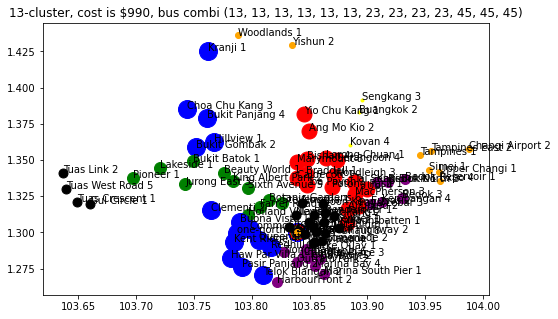

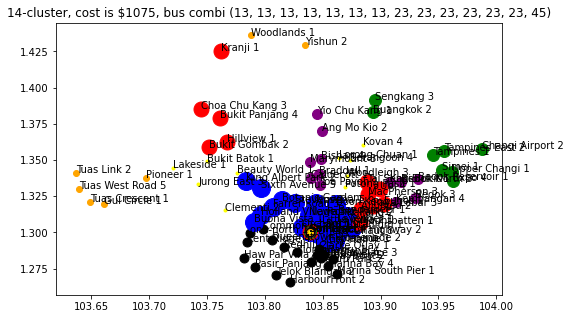

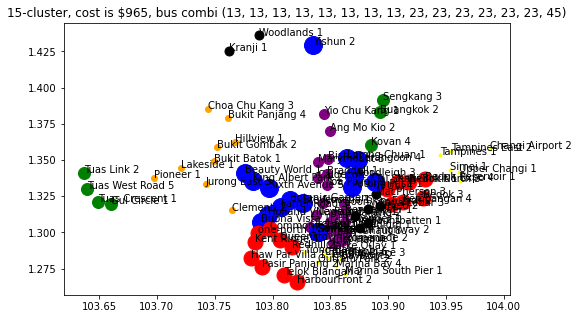

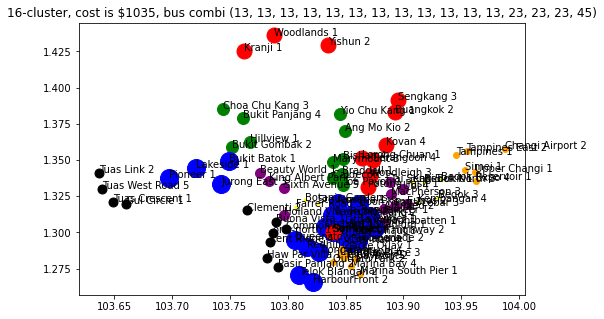

In [25]:
for n_cluster_key in overall_dict.keys():
    n_cluster_dict = overall_dict[n_cluster_key]

    locations_lists = []
    locations_with_no_of_ppl_list = []
    titles = []
    
    # add the after results of this cluster
    for cluster_key in n_cluster_dict.keys():
        if cluster_key != "total_cost" and cluster_key != "no_of_clusters" and cluster_key != "bus_combi":
            cluster_dict = n_cluster_dict[cluster_key]
            locations_lists.append(cluster_dict["locations_with_coordinates"])
            locations_with_no_of_ppl_list.append(cluster_dict["locations_with_no_of_ppl"])
            cost = str(n_cluster_dict["total_cost"])
            bus_combi = str(n_cluster_dict["bus_combi"])
            titles.append(n_cluster_key + ", cost is $" + cost + ", bus combi " + bus_combi)
            
    display_map(locations_lists, locations_with_no_of_ppl_list, titles)